First, we import some tools, including a custom set of methods in 'seedDataFetch.py'

In [1]:
import seedDataFetch
import numpy as numpy
import pandas
import scipy.stats as stats
import matplotlib.pyplot as pl
%matplotlib inline

Next, we need to fetch the seed data from Riot's Amazon S3 buckets. This takes a long time, so comment these lines out if you've already done it!

In [2]:
#seedDataFetch.FetchDataFromRiotS3()
#seedDataFetch.WriteRiotDataToFile('projectData.txt')

After fetching and sorting the data into a JSON formatted file, we read it into the program and load it into a DataFrame object.

In [3]:
data = seedDataFetch.GetRiotData('test.txt')

rawDataFrame = pandas.DataFrame(data)

We're going to look at two separate sets of data as preliminary analysis: game-first objectives and creep-score deltas.

First, let's look at game-first objectives.  There are several important milestones that League of Legends players parse their performance with: first kill, first tower kill, first Baron, first Dragon, first Inhibitor. Let's look at how often these "firsts" result in a win, then perform a chi-squared test to see what sort of correlation there is between "First X" and winning.

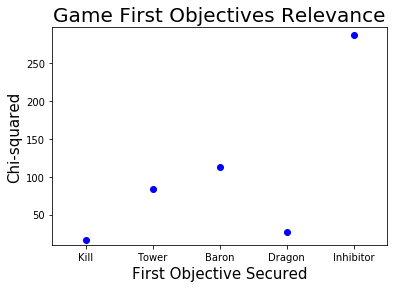

In [4]:
totalGames = 0
bins = numpy.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5,15.0])
wins = numpy.zeros([1,len(bins)])
totals = numpy.zeros([1,len(bins)])
count = 0
notSupport = 0

firstDragon = numpy.array([[1],[2]])
firstBaron = numpy.array([[1],[2]])
firstBlood = numpy.array([[1],[2]])
firstInhibitor = numpy.array([[1],[2]])
firstTower = numpy.array([[1],[2]])

for x in range(0,len(rawDataFrame.index)):
    for y in range(0,len(rawDataFrame.at[x,'matches'])):
        win = 'Win'
        csDeltaAt10 = 0
        for z in range(0,int(len(rawDataFrame.at[x,'matches'][y]['participants'])/2)):
            if rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline']['role']!='DUO_SUPPORT':
                notSupport += 1
            if rawDataFrame.at[x,'matches'][y]['participants'][z]['teamId'] == rawDataFrame.at[x,'matches'][y]['teams'][0]['teamId']:
                win = rawDataFrame.at[x,'matches'][y]['teams'][0]['win']
            else:
                win = rawDataFrame.at[x,'matches'][y]['teams'][1]['win']
            if win == 'Win' and 'csDiffPerMinDeltas' in rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline'].keys(): 
                if rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline']['csDiffPerMinDeltas']['0-10'] > 0:
                    csBin = numpy.digitize(rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline']['csDiffPerMinDeltas']['0-10'], bins)
                    wins[0,csBin] += 1
                    totals[0,csBin] += 1
                else:
                    csBin = numpy.digitize(abs(rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline']['csDiffPerMinDeltas']['0-10']), bins)
                    totals[0,csBin] += 1        
                    count += 1
        totalGames += 1
        if(rawDataFrame.at[x,'matches'][y]['teams'][0]['win'] == 'Win'):
            if(rawDataFrame.at[x,'matches'][y]['teams'][0]['firstDragon']):
                firstDragon[0] = firstDragon[0] + 1
            if(rawDataFrame.at[x,'matches'][y]['teams'][1]['firstDragon']):
                firstDragon[1] = firstDragon[1] + 1
    
            if(rawDataFrame.at[x,'matches'][y]['teams'][0]['firstBaron']):
                firstBaron[0] = firstBaron[0] + 1
            if(rawDataFrame.at[x,'matches'][y]['teams'][1]['firstBaron']):
                firstBaron[1] = firstBaron[1] + 1
                    
            if(rawDataFrame.at[x,'matches'][y]['teams'][0]['firstBlood']):
                firstBlood[0] = firstBlood[0] + 1
            if(rawDataFrame.at[x,'matches'][y]['teams'][1]['firstBlood']):
                firstBlood[1] = firstBlood[1] + 1
                    
            if(rawDataFrame.at[x,'matches'][y]['teams'][0]['firstInhibitor']):
                firstInhibitor[0] = firstInhibitor[0] + 1
            if(rawDataFrame.at[x,'matches'][y]['teams'][1]['firstInhibitor']):
                firstInhibitor[1] = firstInhibitor[1] + 1
                
            if(rawDataFrame.at[x,'matches'][y]['teams'][0]['firstTower']):
                firstTower[0] = firstTower[0] + 1
            if(rawDataFrame.at[x,'matches'][y]['teams'][1]['firstTower']):
                firstTower[1] = firstTower[1] + 1


dragonHalf = (firstDragon[0] + firstDragon[1])/2
dragChi2, dragp = stats.chisquare(firstDragon,f_exp=[dragonHalf,dragonHalf])

baronHalf = (firstBaron[0] + firstBaron[1])/2
baronChi2, baronp = stats.chisquare(firstBaron,f_exp=[baronHalf,baronHalf])

bloodHalf = (firstBlood[0] + firstBlood[1])/2
bloodChi2, bloodp = stats.chisquare(firstBlood,f_exp=[bloodHalf,bloodHalf])

inhibHalf = (firstInhibitor[0] + firstInhibitor[1])/2
inhibChi2, inhibp= stats.chisquare(firstInhibitor,f_exp=[inhibHalf,inhibHalf])

towerHalf = (firstTower[0] + firstTower[1])/2
towerChi2, towerp= stats.chisquare(firstTower,f_exp=[towerHalf,towerHalf])

y = [bloodChi2,towerChi2,baronChi2,dragChi2,inhibChi2]
yMax = 0
for x in range(0,len(y)):
    if y[x] > yMax:
        yMax = y[x]        

x=[1,2,3,4,5]
xticks=['Kill', 'Tower', 'Baron', 'Dragon', 'Inhibitor']
pl.xlim(0.5,5.5)
pl.ylim(10,yMax+10)
pl.plot(x,y, 'bo')
pl.xticks(x,xticks)
pl.ylabel("Chi-squared", size=15)
pl.xlabel("First Objective Secured", size=15)
pl.title("Game First Objectives Relevance", size=20)

Above, we interpret the Chi-squared values as qualitative "importance" - killing the first Baron or Tower are more important than killing the first player or Dragon. First Inhibitor is clearly the most important "first" objective by far - something many players know intuitively.

Let's replot the chi-squared values of game-firsts, omitting the inhibitor.

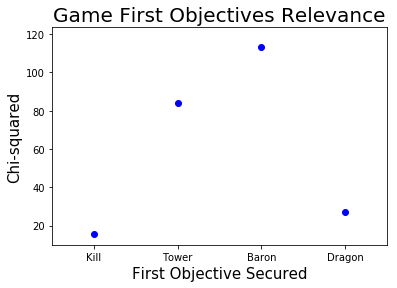

In [5]:
y = [bloodChi2,towerChi2,baronChi2,dragChi2]
yMax = 0
for x in range(0,len(y)-1):
    if y[x] > yMax:
        yMax = y[x]        

x=[1,2,3,4]
xticks=['Kill', 'Tower', 'Baron', 'Dragon']
pl.xlim(0.5,4.5)
pl.ylim(10,yMax+10)
pl.plot(x,y, 'bo')
pl.xticks(x,xticks)
pl.ylabel("Chi-squared", size=15)
pl.xlabel("First Objective Secured", size=15)
pl.title("Game First Objectives Relevance", size=20)

Now we have a better feel for the scale of the other game-firsts. Securing the first Baron or Tower is more important than securing a first Kill or Dragon. In many games, teams are faced with an early-game conundrum: should we trade away the first tower for a first dragon? The analysis above says no - the first tower is a more important objective!

Next, let's look at win percentage against CreepScore/min deltas over the first ten minutes of the game. In other words, we want to see how important it is to gain a large CreepScore lead over your opponent early in the game.

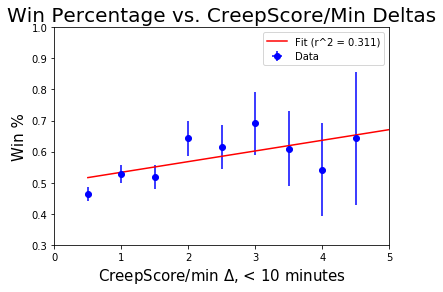

In [6]:
winPercentage = numpy.divide(wins,totals)
winError = numpy.divide(numpy.sqrt(wins),totals)

bins = numpy.reshape(bins, winPercentage.shape)
bins = bins.reshape((10,))
winPercentage = winPercentage.reshape((10,))
winError = winError.reshape((10,))
 

slope, intercept, r_value, p_value, std_err = stats.linregress(bins[:8],y=winPercentage[:8])
pl.xlim(0,5)
pl.ylim(0.3,1)
pl.errorbar(bins,winPercentage,xerr=0,yerr=winError,fmt='bo', label = 'Data')
r2 = round((r_value*r_value),3)
pl.ylabel("Win %", size=15)
pl.xlabel("CreepScore/min $\Delta$, < 10 minutes", size=15)
pl.plot(bins,bins*slope + intercept, 'r', label = 'Fit (r^2 = ' + str(r2) + ')')
pl.legend()
pl.title('Win Percentage vs. CreepScore/Min Deltas', size=20)
pl.show()

It looks like establishing an early CreepScore lead moves Win % above 50% - though for large values of CS/min, we don't have enough data to be confident in those measurements (massive error bars).

Later, we'll look at how CS/min deltas can lead to important first objectives.